# Kaggle Titanic: 2 - Data Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add the "src" directory to the system path
project_root  = os.path.abspath('../')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import PathManager
from src.project_specific import run_dm_pipeline, plot_categorical_features_vs_target, plot_numerical_features_vs_target, chi2_categorical_features, chi2_all_categorical, analyze_correlation, cramers_v, chi_square_test_train, preprocessing_log_reg



## Working Environment

### Variables & Paths

In [2]:
path_manager = PathManager(dataset_name="titanic")
print("\n" + str(path_manager))

DATASET_PATH = path_manager.dataset_path
WORKING_PATH = path_manager.working_path

print(f"\nDATASET_PATH: {DATASET_PATH}")
print(f"WORKING_PATH: {WORKING_PATH}")

Running on local.
Dataset directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working directory: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

Dataset Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
Working Path: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working

DATASET_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data
WORKING_PATH: c:\Users\Florent\Documents\data_science\kaggle-titanic\data\working


### Datasets

In [3]:
test = pd.read_csv(os.path.join(DATASET_PATH, "test.csv"))
train = pd.read_csv(os.path.join(DATASET_PATH, "train.csv"))

datasets_dict = {
    "train": train,
    "test": test
}

test_memory = test.memory_usage(deep=True).sum()
train_memory = train.memory_usage(deep=True).sum()
print(f"Test dataset memory usage: {test_memory / (1024**2):.2f} MB")
print(f"Train dataset memory usage: {train_memory / (1024**2):.2f} MB")

Test dataset memory usage: 0.13 MB
Train dataset memory usage: 0.28 MB


## Data Management

In [4]:
result = run_dm_pipeline(test, train)

categorical_features = result["categorical_features"]
numerical_features = result["numerical_features"]
target = result["target"]

Target Variable: Survived
Target Variable 'Survived' not found in DataFrame test.
'Embarked' is S for passenger at index 152. Imputing 'Fare' with median fare 8.05 for 'Pclass' 3 and 'Embarked' S.
Remaining missing 'Fare' values in test dataset: 0
Remaining missing 'Embarked' values in train dataset: 0
Remaining missing 'Age' values in the combined dataset: 0

Categorical_features: ['Pclass', 'Sex', 'Embarked', 'Simplified_Title', 'Deck', 'Is_Alone', 'AgeGroup']
Numerical features: ['Family_Size', 'LogFare']
target: Survived


In [5]:
test_df = result["test"][categorical_features + numerical_features]
train_df = result["train"][categorical_features + numerical_features + [target]]

## Bivariate Analysis vs Target

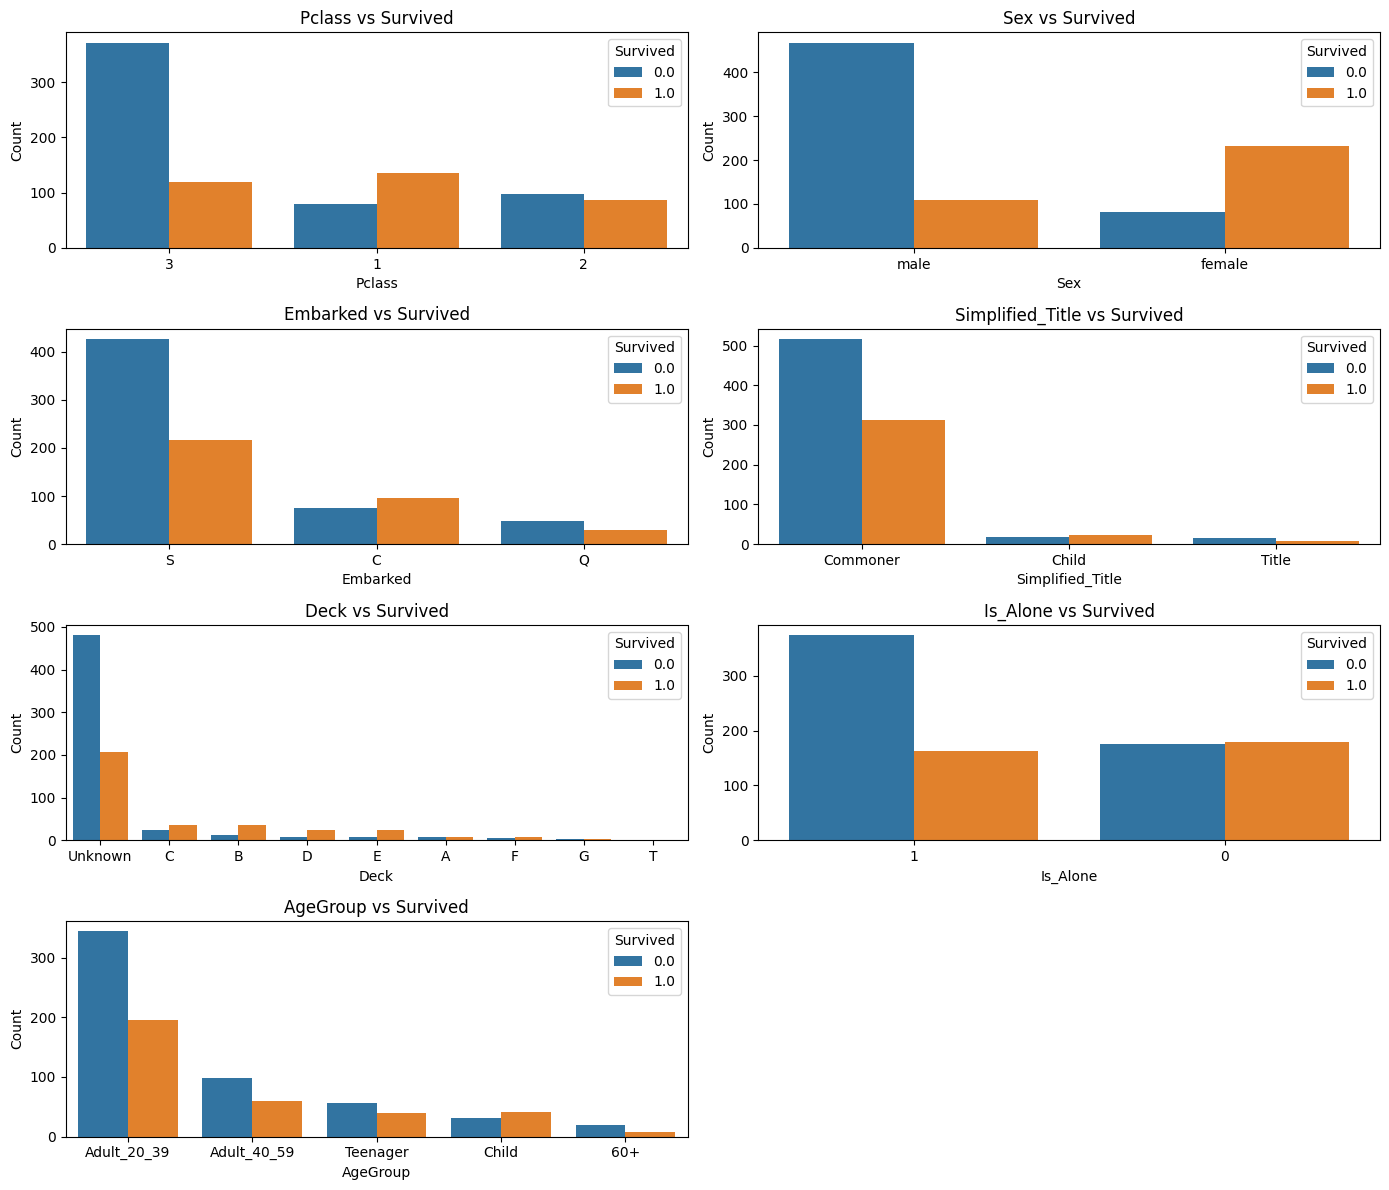

In [6]:
plot_categorical_features_vs_target(train_df, categorical_features, target, max_cols=2, figsize=(14, 12))

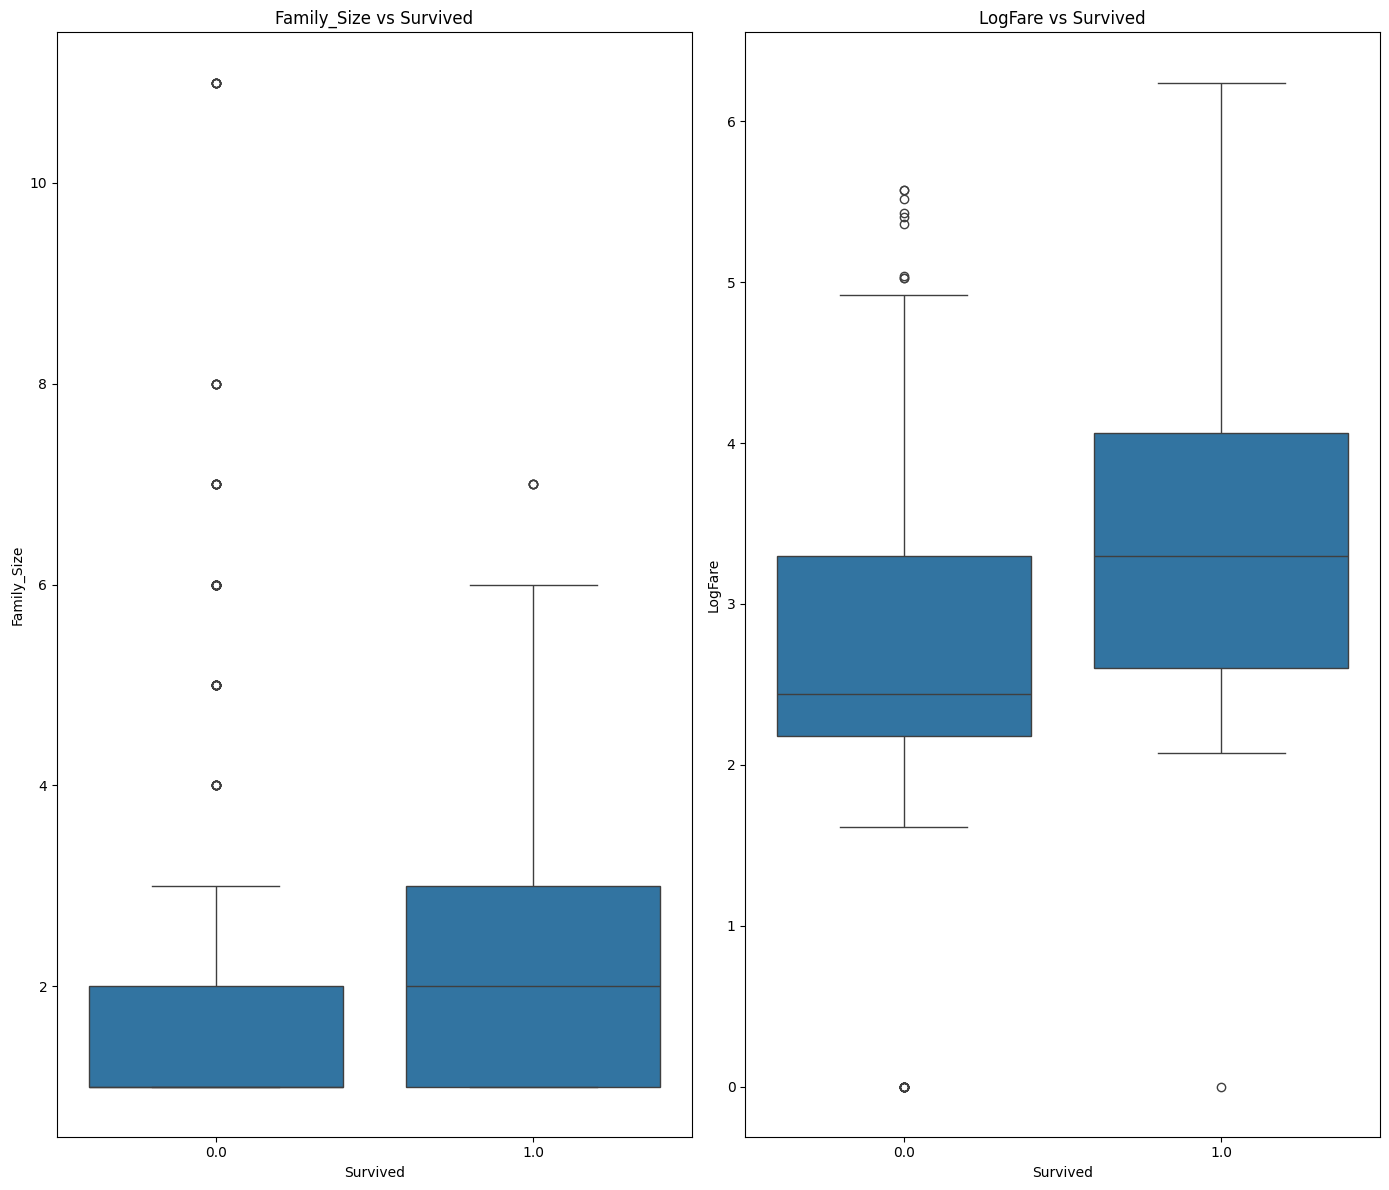

In [7]:
plot_numerical_features_vs_target(train_df, numerical_features, target, max_cols=2, figsize=(14, 12))

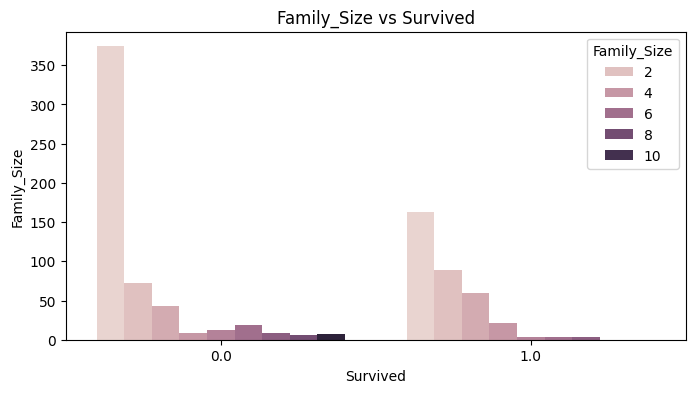

In [8]:
# Countplot for Family_Size
plt.figure(figsize=(8, 4))
sns.countplot(x=target, hue='Family_Size', data=train_df)
plt.title(f'Family_Size vs {target}')
plt.xlabel(target)
plt.ylabel('Family_Size')
plt.show()

## Correlation Analysis
### Numerical features

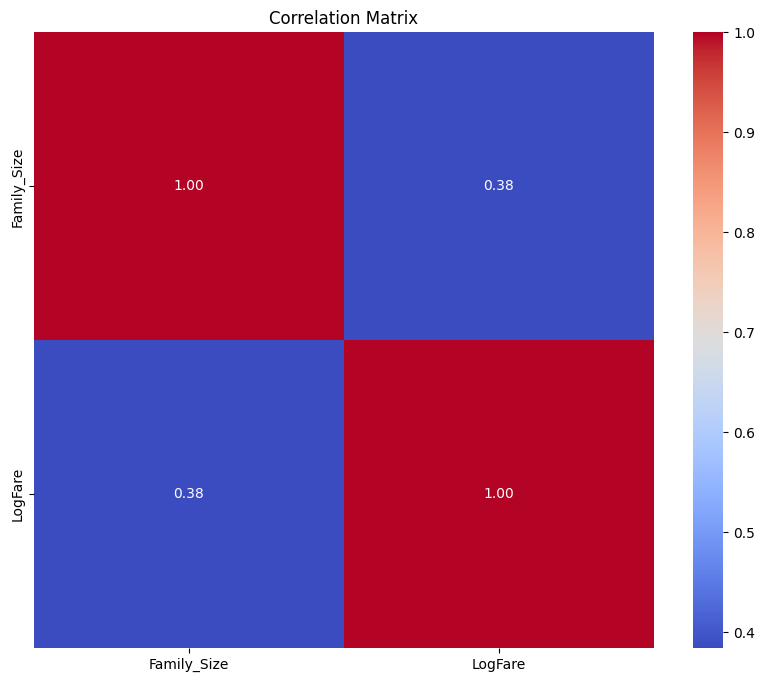

In [9]:
corr = train_df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

             Family_Size  LogFare
Family_Size          1.0      NaN
LogFare              NaN      1.0


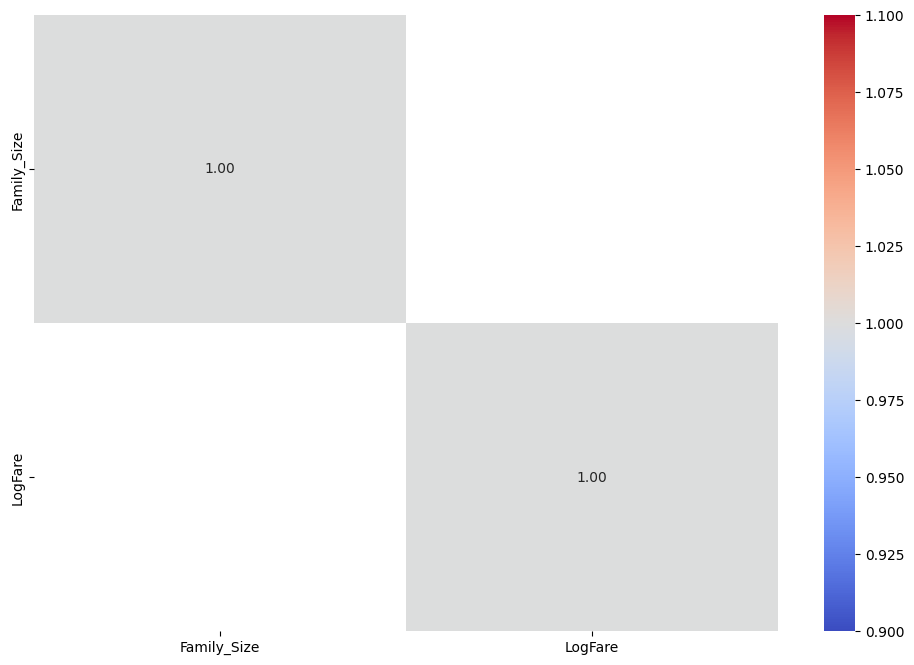

In [10]:
# not useful here, juste to have it in the process:

# Filter the correlation matrix for correlations with an absolute value of at least 0.6
filtered_corr_matrix = corr[(corr.abs() >= 0.6)]

# Drop rows and columns that are entirely NaN (where all correlations were less than 0.6)
filtered_corr_matrix.dropna(how='all', axis=0, inplace=True)
filtered_corr_matrix.dropna(how='all', axis=1, inplace=True)

# Print the filtered correlation matrix
print(filtered_corr_matrix)

# Visualize the filtered correlation matrix with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Categorical features

In [11]:
results = chi2_categorical_features(train_df, categorical_features, target_col=target)
results

,Feature,Chi2_Statistic,P_Value,Significant
0,Pclass,102.888989,4.549252e-23,True
1,Sex,260.717020,1.197357e-58,True
2,Embarked,28.005089,8.294157e-07,True
3,Simplified_Title,6.777604,3.374909e-02,True
4,Deck,99.164161,6.326020e-18,True
5,Is_Alone,36.000514,1.972654e-09,True
6,AgeGroup,13.550294,8.877682e-03,True


In [12]:
results = chi2_all_categorical(train_df, categorical_features)
results

,Variable_1,Variable_2,Chi2_Statistic,P_Value,Significant
0,Pclass,Sex,16.971499,2.063886e-04,True
1,Pclass,Embarked,127.013309,1.694396e-26,True
2,Pclass,Simplified_Title,35.343733,3.948151e-07,True
3,Pclass,Deck,652.408317,1.708918e-128,True
4,Pclass,Is_Alone,16.459030,2.666656e-04,True
5,Pclass,AgeGroup,139.426779,3.122313e-26,True
6,Sex,Embarked,14.244474,8.069595e-04,True
7,Sex,Simplified_Title,30.442513,2.451841e-07,True
8,Sex,Deck,37.643810,8.758898e-06,True
9,Sex,Is_Alone,80.857313,2.426184e-19,True


Let's focus on some features:

In [13]:
result = analyze_correlation(train_df, 'Pclass', 'Embarked')

print("Contingency Table (Observed):")
print(result["contingency_table"])
print("\nExpected Frequencies:")
print(result["expected_frequencies"])

Contingency Table (Observed):
Embarked   C   Q    S
Pclass               
1         87   2  127
2         17   3  164
3         66  72  353

Expected Frequencies:
Embarked          C          Q           S
Pclass                                    
1         41.212121  18.666667  156.121212
2         35.106622  15.901235  132.992144
3         93.681257  42.432099  354.886644


In [14]:
result = analyze_correlation(train_df, 'Deck', 'Embarked')

print("Contingency Table (Observed):")
print(result["contingency_table"])
print("\nExpected Frequencies:")
print(result["expected_frequencies"])

Contingency Table (Observed):
Embarked   C   Q    S
Deck                 
A          7   0    8
B         24   0   23
C         21   2   36
D         13   0   20
E          5   1   26
F          1   1   11
G          0   0    4
T          0   0    1
Unknown   99  73  515

Expected Frequencies:
Embarked           C          Q           S
Deck                                       
A           2.861953   1.296296   10.841751
B           8.967452   4.061728   33.970819
C          11.257015   5.098765   42.644220
D           6.296296   2.851852   23.851852
E           6.105499   2.765432   23.129068
F           2.480359   1.123457    9.396184
G           0.763187   0.345679    2.891134
T           0.190797   0.086420    0.722783
Unknown   131.077441  59.370370  496.552189


- It seems that 3rd class passengers are more likely to embark from Southampton, and 1st class passengers are more likely to embark from Cherbourg.
- there is a link between Pclass and Deck but there might be too many categories for a chi2

Let's visualize the correaltions with Creamer's V heatmap:

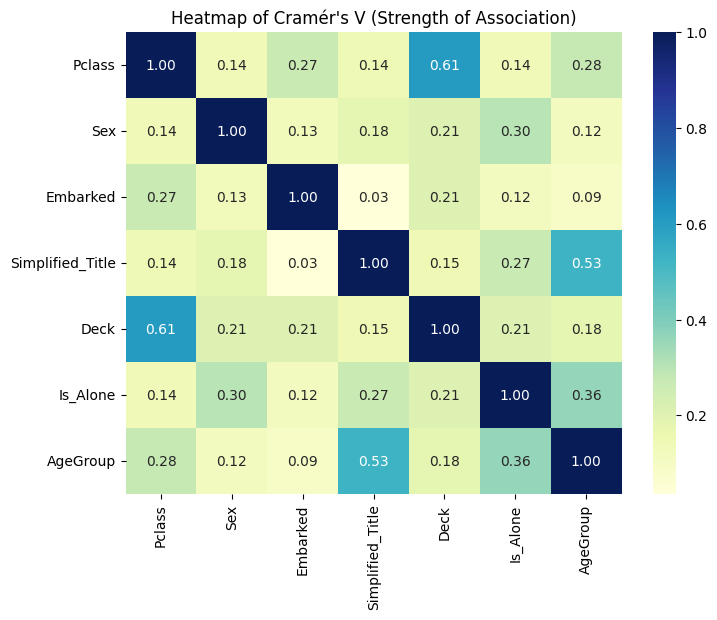

In [15]:
# Calculate Cramér's V for all pairs of categorical features
cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for var1 in categorical_features:
    for var2 in categorical_features:
        if var1 == var2:
            cramers_v_matrix.loc[var1, var2] = 1.0
        else:
            cramers_v_matrix.loc[var1, var2] = cramers_v(train_df[var1], train_df[var2])

# Convert to float for heatmap compatibility
cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Heatmap of Cramér's V (Strength of Association)")
plt.show()

## Train vs Test

### Numerical features

In [16]:
train_summary = train_df[numerical_features].describe()
test_summary = test_df[numerical_features].describe()

print("Train Set Summary Statistics:")
print(train_summary)
print("\nTest Set Summary Statistics:")
print(test_summary)

Train Set Summary Statistics:
       Family_Size     LogFare
count   891.000000  891.000000
mean      1.904602    2.962246
std       1.613459    0.969048
min       1.000000    0.000000
25%       1.000000    2.187218
50%       1.000000    2.737881
75%       2.000000    3.465736
max      11.000000    6.240917

Test Set Summary Statistics:
       Family_Size     LogFare
count   418.000000  418.000000
mean      1.839713    3.014141
std       1.519072    0.967655
min       1.000000    0.000000
25%       1.000000    2.185579
50%       1.000000    2.737881
75%       2.000000    3.480373
max      11.000000    6.240917


In [17]:
# Perform Kolmogorov-Smirnov test for numerical features
for feature in numerical_features:
    ks_stat, p_value = ks_2samp(train_df[feature].dropna(), test_df[feature].dropna())
    print(f"{feature} - KS Statistic: {ks_stat}, P-value: {p_value}")

Family_Size - KS Statistic: 0.021737846299249807, P-value: 0.9988008167693302
LogFare - KS Statistic: 0.03877960895504755, P-value: 0.7667475066503155


### Categorical features

In [18]:
# Perform Chi-Square train vs test for each categorical feature
for feature in categorical_features:
    chi2, p = chi_square_test_train(train_df, test_df, feature)
    print(f"{feature} - Chi-Square: {chi2}, P-value: {p}")

Pclass - Chi-Square: 1.0134212156403517, P-value: 0.6024740965496366
Sex - Chi-Square: 0.111202258413833, P-value: 0.7387795114785529
Embarked - Chi-Square: 7.975616060374664, P-value: 0.018540309410284377
Simplified_Title - Chi-Square: 2.426345081869747, P-value: 0.2972527354486881
Deck - Chi-Square: 5.128030170181437, P-value: 0.7438085726944139
Is_Alone - Chi-Square: 0.0007844079192413937, P-value: 0.9776563421735666
AgeGroup - Chi-Square: 2.2861670187496066, P-value: 0.6832886928427433


- Embarked distributions are not the same between Test and Train.

## Analyses

### Logistic Regression

Preprocessing:
- Encoding categorical features
- Scaling numerical features
- Train-Test split for validation

*Encoding categorical features:*

Logistic regression assumes numerical input features, so categorical variables must be transformed into a numerical representation.

If the categorical feature is ordinal (e.g., Education levels: High School, Bachelor’s, Master’s), it can encoded with integers (e.g., 0, 1, 2) to preserve the order.  
If the feature is nominal (e.g., Sex: Male, Female, or Embarked: C, Q, S), one-hot encoding is typically necessary to avoid assigning an arbitrary ordinal relationship between the categories, and then a category needs to be droppeds to avoid dependance and multicolonearity. THe dropped level becomes the baseline.

We can choose the most represented category as the level to drop, as it can reduce overfitting and simplifies interpretation.

#### Log Reg on all features

In [19]:
X_train, y_train = preprocessing_log_reg(
    data=train_df,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    target=target
)

Most represented levels: {'Pclass': '3', 'Sex': 'male', 'Embarked': 'S', 'Simplified_Title': 'Commoner', 'Deck': 'Unknown', 'Is_Alone': '1', 'AgeGroup': 'Adult_20_39'}


In [20]:
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit(method='bfgs', maxiter=50000)

Optimization terminated successfully.
         Current function value: 0.399286
         Iterations: 191
         Function evaluations: 193
         Gradient evaluations: 193


In [21]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      868
Method:                           MLE   Df Model:                           22
Date:                Sun, 19 Jan 2025   Pseudo R-squ.:                  0.4004
Time:                        15:39:00   Log-Likelihood:                -355.76
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.107e-86
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.4533      0.207    -11.846      0.000      -2.859      -2.047
Family_Size               -0.8831      0.204     -4.319      0.000      -1.284      -0.482
LogF

Significant p-values:

- Family_Size: Negative coefficient (-0.8831). Larger family sizes are associated with lower odds of survival.
- Sex_female: Positive coefficient (3.2184). Being female greatly increases the odds of survival.
- Pclass_1: Positive coefficient (1.6167). First-class passengers had higher survival odds.
- Pclass_2: Positive coefficient (1.0870). Second-class passengers also had higher odds compared to third-class passengers.
- Simplified_Title_Child: Positive coefficient (3.4012). Children had significantly higher odds of survival.
- Deck_E: Positive coefficient (1.5068). Passengers on Deck E had better survival odds.
- AgeGroup_Adult_40_59: Negative coefficient (-0.7511). Adults aged 40–59 were less likely to survive.

In [22]:
odds_ratios = np.exp(result.params)
print(odds_ratios)

const                      0.086011
Family_Size                0.413503
LogFare                    1.464290
Pclass_1                   5.036452
Pclass_2                   2.965500
Sex_female                24.987465
Embarked_C                 1.577074
Embarked_Q                 1.166836
Simplified_Title_Child    30.000021
Simplified_Title_Title     1.250177
Deck_A                     1.994582
Deck_B                     1.947679
Deck_C                     1.218035
Deck_D                     3.140693
Deck_E                     4.512057
Deck_F                     2.051971
Deck_G                     0.563332
Deck_T                     0.000176
Is_Alone_0                 0.706395
AgeGroup_Child             1.345714
AgeGroup_Teenager          0.965388
AgeGroup_Adult_40_59       0.471866
AgeGroup_60+               0.358047
dtype: float64


Checking multicolinearity with VIF:  
High VIF values (>5 or >10) indicate collinearity.

In [23]:
X = X_train.drop('const', axis=1)  # Drop intercept column
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                   feature       VIF
0              Family_Size  1.423800
1                  LogFare  1.612971
2                 Pclass_1  5.715461
3                 Pclass_2  1.351164
4               Sex_female  2.002665
5               Embarked_C  1.381588
6               Embarked_Q  1.103590
7   Simplified_Title_Child  2.434216
8   Simplified_Title_Title  1.140075
9                   Deck_A  1.327750
10                  Deck_B  2.028961
11                  Deck_C  2.299214
12                  Deck_D  1.559073
13                  Deck_E  1.446523
14                  Deck_F  1.046950
15                  Deck_G  1.051659
16                  Deck_T  1.026771
17              Is_Alone_0  2.346683
18          AgeGroup_Child  2.655469
19       AgeGroup_Teenager  1.128182
20    AgeGroup_Adult_40_59  1.461460
21            AgeGroup_60+  1.109253


Some levels on different features may contrain the same information: Simplified_Tiutle="CHild" with AgeGroup, Is_ALone with Family_Size.  
Maybe to some extent Deck with Pclass or Embarked.  
Let's remove some of these features from the model.

#### Log Reg on selected features

In [24]:
categorical_features_selected = [feature for feature in categorical_features if feature != "Simplified_Title"]
numerical_features_selected = [feature for feature in numerical_features if feature != "Family_Size"]

In [25]:
X_train, y_train = preprocessing_log_reg(
    data=train_df,
    categorical_features=categorical_features_selected,
    numerical_features=numerical_features_selected,
    target=target
)

Most represented levels: {'Pclass': '3', 'Sex': 'male', 'Embarked': 'S', 'Deck': 'Unknown', 'Is_Alone': '1', 'AgeGroup': 'Adult_20_39'}


In [26]:
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit(method='bfgs', maxiter=50000)
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.430633
         Iterations: 170
         Function evaluations: 172
         Gradient evaluations: 172
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      871
Method:                           MLE   Df Model:                           19
Date:                Sun, 19 Jan 2025   Pseudo R-squ.:                  0.3533
Time:                        15:39:00   Log-Likelihood:                -383.69
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 4.276e-77
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const          

Significant Features (p < 0.05)

- Pclass_1: Coefficient = 1.6366. First-class passengers are significantly more likely to survive than third-class passengers.
- Pclass_2: Coefficient = 1.2919. Second-class passengers are also more likely to survive than third-class passengers.
- Sex_female: Coefficient = 2.6771. Females are significantly more likely to survive than males.
- Embarked_C: Coefficient = 0.6102. Passengers who embarked at Cherbourg have better odds of survival.
- Deck_D: Coefficient = 1.2047. Passengers on Deck D have better survival odds.
- Deck_E: Coefficient = 1.6431. Passengers on Deck E are significantly more likely to survive.
- AgeGroup_Child: Coefficient = 1.4324. Children have much higher odds of survival.
- AgeGroup_Adult_40_59: Coefficient = -0.7155. Adults aged 40-59 are less likely to survive compared to younger adults.

Marginally Significant Features (0.05 < p < 0.10)

- LogFare: Coefficient = 0.3132 (p = 0.085). Higher fares are associated with better survival odds.
- Is_Alone_0: Coefficient = -0.3983 (p = 0.069). Not being alone (having family onboard) slightly reduces survival odds.
- AgeGroup_60+: Coefficient = -1.0796 (p = 0.063). Elderly passengers (60+) are less likely to survive.

Overall these results make a bit more sense than those of the logistic regression on all the features.

In [27]:
odds_ratios = np.exp(result.params)
print(odds_ratios)

const                    0.086298
LogFare                  1.367785
Pclass_1                 5.137517
Pclass_2                 3.639608
Sex_female              14.542381
Embarked_C               1.840749
Embarked_Q               1.638459
Deck_A                   2.035743
Deck_B                   2.105385
Deck_C                   1.232205
Deck_D                   3.335857
Deck_E                   5.171042
Deck_F                   3.006606
Deck_G                   0.580525
Deck_T                   0.000121
Is_Alone_0               0.671466
AgeGroup_Child           4.188565
AgeGroup_Teenager        1.090798
AgeGroup_Adult_40_59     0.488969
AgeGroup_60+             0.339746
dtype: float64
